In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cv2
import xraylib
import random
import scipy.ndimage as ndimage
import tifffile

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2**11  # object size in x,y
nz = 2**11  # object size in z    

voxelsize = 10e-9*2048/n # [m] object voxel size 
energy = 33.35  # [keV] x-ray energy    
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy # [m]
focusToDetectorDistance = 1.28 # [m]
sx0 = 3.7e-4 # [m] motor offset from the focal spot

npos = 16 # number of codes for structure illumination
z1 = np.tile(np.array([4e-3]),1)-sx0 # positions of the sample (1 position is enough when using several codes)
z2 = focusToDetectorDistance-z1 # propagation distance between the code and detector

magnifications = (z1+z2)/z1 # magnification when propagating from the sample to the code
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/(z1+z2) # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distances due to magnified probes

## Form tranmistance function for the code made of gold with 1um feature size, and 3um thickness

In [3]:
# make some large global code first
# random.seed(10)
# nill = 2**13
# ill_global = np.zeros([4,nill,nill],dtype='bool')
# for k in  range(ill_global.shape[0]):
#     ill0 = np.zeros([nill*nill],dtype='bool')
#     ill_ids = random.sample(range(0, nill*nill), nill*nill//2)
#     ill0[ill_ids] = 1
#     ill_global[k] = ill0.reshape(nill,nill)
# np.save('ill_global',ill_global)
ill_global = np.load('ill_global.npy')
# form codes for simulations
ill_feature_size = 1e-6
nn = 1024
voxelsizen = 10e-9*2048/nn # [m] object voxel size 
nill = int(nn*voxelsizen//(ill_feature_size*2))*2
print(nill)
ill = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill.shape[0]):
    ill0 = ill_global[k]
    ill[k] = ill0[ill0.shape[0]//2-nill//2:ill0.shape[0]//2+(nill)//2,ill0.shape[1]//2-nill//2:ill0.shape[1]//2+(nill)//2]#.reshape(nill,nill)
ill = ndimage.zoom(ill,[1,nn/nill,nn/nill],order=0,grid_mode=True,mode='grid-wrap')

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = 3*1e-6/voxelsizen # thickness in pixels

v = np.zeros(ill.shape[1:],dtype='bool')
v[nn//nill*3+1:-nn//nill*3+1,nn//nill*3+1:-nn//nill*3+1]=1
ill*=v
# form Transmittance function
Rill = ill*(-delta+1j*beta)*thickness 

v = np.arange(-nn//2,nn//2)/nn
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-300*(vx**2+vy**2))
fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(Rill)))
Rill = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v)))

psiill = np.exp(1j * Rill * voxelsizen * 2 * np.pi / wavelength).astype('complex64')
psiill = ndimage.zoom(psiill,(1,n//nn,n/nn),order=0)

20


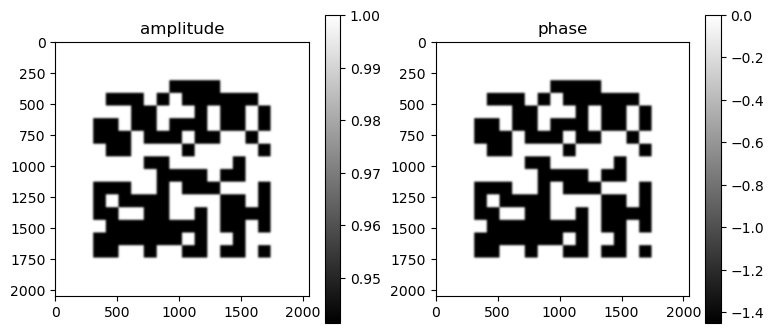

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psiill[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psiill[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

## Read one probe

In [5]:
prb = np.ones([1,nz,n],dtype='complex64')
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')[0]
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')[0]/4# note!!!!!!!!!!!!!!
prb[:] = prb_abs*np.exp(1j*prb_phase)  
# prb[:]=1

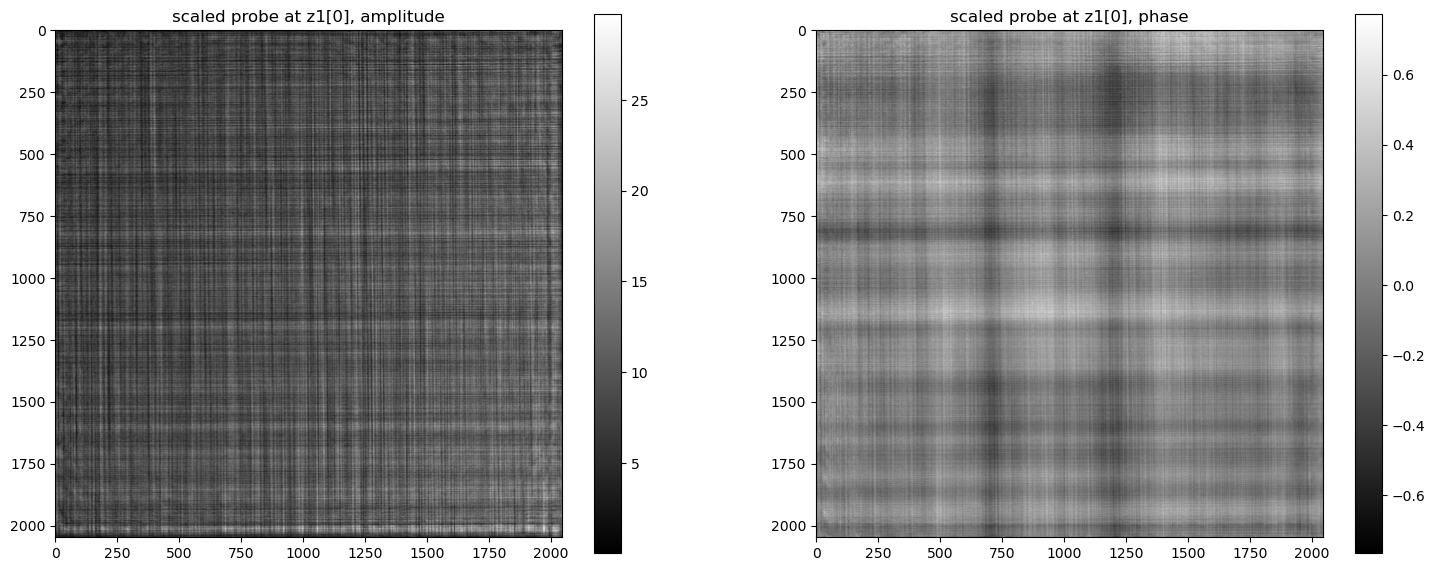

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('scaled probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('scaled probe at z1[0], phase')
fig.colorbar(im)

## Create a solver class for holography, note the class has additional parameters distances2 to be able to compute Fresnel propagation between the sample and probe

In [7]:
pslv = holotomo.SolverHolo(1, nz, n, 1, voxelsize, energy, distances, norm_magnifications) 
voxelsize

1e-08

In [8]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    # tmp = np.zeros([psi.shape[0], 2*nz, 2*n], dtype='float32')
    # tmp[:, nz//2:3*nz//2, n//2:3*n//2] = psi
    tmp = np.pad(psi,((0,0),(nz//2,nz//2),(n//2,n//2)), 'wrap')
    [x, y] = np.meshgrid(np.fft.fftfreq(2*n),
                         np.fft.fftfreq(2*nz))
    shift = np.exp(-2*np.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = np.fft.ifft2(shift*np.fft.fft2(tmp))
    res = res0[:, nz//2:3*nz//2, n//2:3*n//2]
    return res

## Model data

In [9]:
import cupy as cp

shifts = (cp.random.random([npos,2])-0.5)*3*n/nill
print(shifts)
# shifts[:] = 0


def apply_shift(psi, p):
    """Apply shift for all projections."""
    # tmp = cp.zeros([psi.shape[0], 2*nz, 2*n], dtype='complex64')
    # tmp[:, nz//2:3*nz//2, n//2:3*n//2] = psi
    tmp = cp.pad(psi,((0,0),(nz//2,nz//2),(n//2,n//2)),'wrap')
    [x, y] = cp.meshgrid(cp.fft.fftfreq(2*n),
                         cp.fft.fftfreq(2*nz))
    shift = cp.exp(-2*np.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.ifft2(shift*np.fft.fft2(tmp))
    res = res0[:, nz//2:3*nz//2, n//2:3*n//2]
    return res
def fwd_nfp(psi,prb):
    psi = cp.tile(psi,[npos,1,1])
    psi = apply_shift(psi,shifts)[:,cp.newaxis].astype('complex64')#.copy()    
    # psi = psi[:,cp.newaxis].astype('complex64')#.copy()    
    fpsi = cp.zeros([npos,1,1,n,n],dtype='complex64')
    for k in range(npos):    
        fpsi[k] = pslv.fwd_holo(psi[k],prb)
    return fpsi

fpsi = fwd_nfp(cp.array(psiill),cp.array(prb)).get()
data = np.abs(fpsi)**2

[[ 122.35517379  111.56234075]
 [-107.05746256  -96.46117184]
 [ -88.72517988   55.8681792 ]
 [  23.33347724  109.68480464]
 [ 147.74293655   25.88469463]
 [-135.0896283  -127.16377001]
 [ -55.9637667    -2.21141988]
 [ 132.61362917  -77.50182807]
 [-121.20130874  -19.40394475]
 [-132.01931123   48.20349252]
 [ -51.88126063 -137.52288547]
 [ -54.24266113  -76.81051889]
 [ -63.61358405  -60.74730973]
 [   2.44752441  -14.23158371]
 [ -10.60646301    8.20340945]
 [ -68.33966779  -64.09449088]]


## Show data and flat fields for different npos

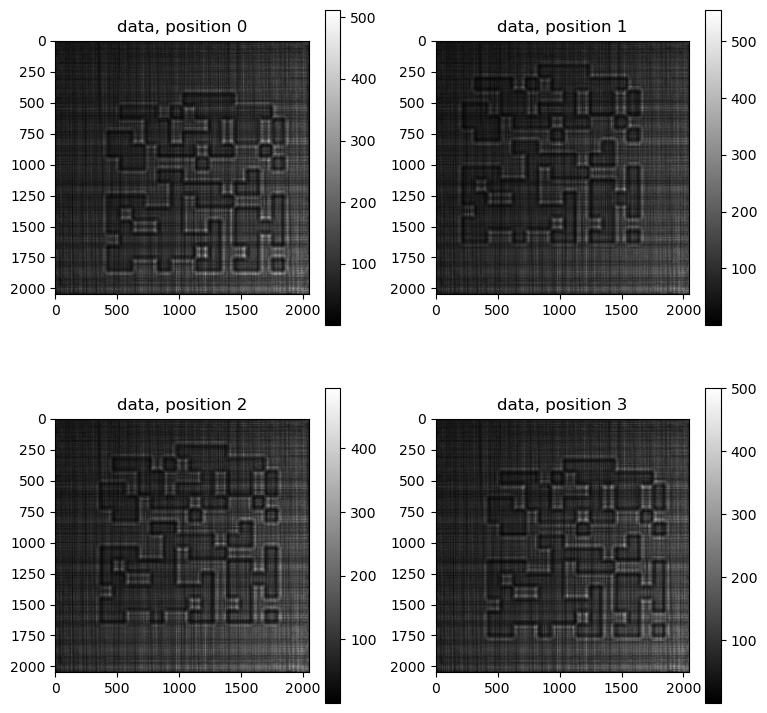

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0,0],cmap='gray')
axs[0,0].set_title('data, position 0')
fig.colorbar(im)
im=axs[0,1].imshow(data[1,0,0],cmap='gray')
axs[0,1].set_title('data, position 1')
fig.colorbar(im)
im=axs[1,0].imshow(data[2,0,0],cmap='gray')
axs[1,0].set_title('data, position 2')
fig.colorbar(im)
im=axs[1,1].imshow(data[3,0,0],cmap='gray')
axs[1,1].set_title('data, position 3')
fig.colorbar(im)


# Save data and flat fields

In [11]:
for k in range(npos):
    dxchange.write_tiff(data[k],f'data/modeling/data_codes_{n}_{k}',overwrite=True)
dxchange.write_tiff(np.abs(prb),f'data/modeling/prb_abs{n}',overwrite=True)
dxchange.write_tiff(np.angle(prb),f'data/modeling/prb_angle{n}',overwrite=True)
dxchange.write_tiff(np.abs(psiill),f'data/modeling/psiill_abs{n}',overwrite=True)
dxchange.write_tiff(np.angle(psiill),f'data/modeling/psiill_angle{n}',overwrite=True)
np.save('shifts.npy',shifts.get())


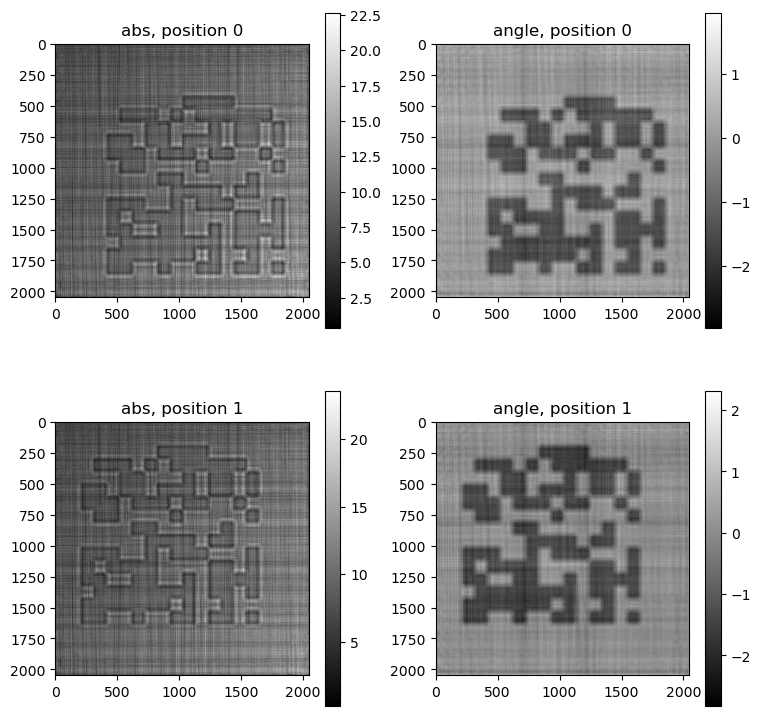

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(np.abs(fpsi[0,0,0]),cmap='gray')
axs[0,0].set_title('abs, position 0')
fig.colorbar(im)
im=axs[0,1].imshow(np.angle(fpsi[0,0,0]),cmap='gray')
axs[0,1].set_title('angle, position 0')
fig.colorbar(im)
im=axs[1,0].imshow(np.abs(fpsi[1,0,0]),cmap='gray')
axs[1,0].set_title('abs, position 1')
fig.colorbar(im)
im=axs[1,1].imshow(np.angle(fpsi[1,0,0]),cmap='gray')
axs[1,1].set_title('angle, position 1')
fig.colorbar(im)